In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in current directory:")
for item in os.listdir('.'):
    if os.path.isfile(item):
        print(f"  {item}")

Already up to date.
Content of dir:
total 216
drwxr-xr-x  3663 davide  staff  117216 27 Nov 13:49 dataset
-rw-r--r--     1 davide  staff  110184 27 Nov 13:49 dataset.csv
drwxr-xr-x     5 davide  staff     160  2 Dec 09:31 ML_Project_first_term


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

data = pd.read_csv('dataset.csv')
data['class_combined'] = data['type'] + '_' + data['state']

X = data[['name']]
y = data['class_combined']

random_state = 67

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=random_state,
    stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=random_state,
    stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 2564
Validation size: 548
Test size: 550


In [ ]:
import os
import numpy as np
from PIL import Image

import torchvision.transforms as T
import torch

size = 64

normalize = T.Compose([
    T.ToTensor(),
])

val_transform = T.Compose([
    T.Resize((size, size)),
    normalize,
])

aug_1 = T.Compose([
    T.Resize((size, size)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    normalize
])

aug_2 = T.Compose([
    T.Resize((size, size)),
    T.RandomVerticalFlip(0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    normalize
])

aug_3 = T.Compose([
    T.Resize((size, size)),
    T.RandomHorizontalFlip(0.3),
    T.RandomVerticalFlip(0.3),
    T.RandomRotation(5),
    T.ColorJitter(brightness=0.07, contrast=0.07),
    normalize
])

aug_blur = T.Compose([
    T.Resize((size, size)),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    T.RandomHorizontalFlip(0.4),
    T.ColorJitter(brightness=0.08, contrast=0.08),
    normalize
])

aug_crop = T.Compose([
    T.RandomResizedCrop(size, scale=(0.85, 1.0), ratio=(0.95, 1.05)),
    T.RandomHorizontalFlip(0.4),
    T.RandomRotation(8),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    normalize
])

aug_noise = T.Compose([
    T.Resize((size, size)),
    T.RandomHorizontalFlip(0.3),
    T.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.1),
    T.RandomRotation(7),
    normalize
])

train_transform = [val_transform, aug_1, aug_2, aug_3, aug_blur, aug_crop, aug_noise, aug_3]

        
def load_images_as_numpy(df, labels, root_dir, transform):
    X_list = []
    y_list = []
    for i in range(len(df)):
        img_path = os.path.join(root_dir, df.iloc[i]["name"])
        img = Image.open(img_path).convert("RGB")
        if isinstance(transform, list):
            for t in transform:
                img_t = t(img)
                img_np = img_t.numpy()
                X_list.append(img_np)
                y_list.append(labels.iloc[i])
        else:
            img_t = transform(img)
            img_np = img_t.numpy()
            X_list.append(img_np)
            y_list.append(labels.iloc[i])
            
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

root_dir = "datasetV1"

X_train_np, y_train_np = load_images_as_numpy(X_train, y_train, root_dir, train_transform)
X_val_np, y_val_np     = load_images_as_numpy(X_val,   y_val,   root_dir, val_transform)
X_test_np, y_test_np   = load_images_as_numpy(X_test,  y_test,  root_dir, val_transform)

print(X_train_np.shape, y_train_np.shape)
print(X_val_np.shape, y_val_np.shape)
print(X_test_np.shape, y_test_np.shape)

(20512, 3, 64, 64) (20512,)
(548, 3, 64, 64) (548,)
(550, 3, 64, 64) (550,)


## Only color hist (actual baseline)

In [4]:
import numpy as np
import cv2

def color_hist_features(X, bins=16, img_shape=(3, size, size)):
    n_samples = X.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = cv2.cvtColor((img * 255.0).astype(np.uint8), cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats


In [5]:
X_train_color = color_hist_features(X_train_np, bins=64)
X_val_color   = color_hist_features(X_val_np,   bins=64)
X_test_color  = color_hist_features(X_test_np,  bins=64)

print(X_train_color.shape)
print(X_val_color.shape)
print(X_test_color.shape)


(20512, 192)
(548, 192)
(550, 192)


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

scaler_color = StandardScaler()
X_train_color_std = scaler_color.fit_transform(X_train_color)
X_val_color_std = scaler_color.transform(X_val_color)

k_list = [7, 9, 11, 13]
C_list = [20, 30, 40]
rf_depth_list = [30, 40]

print("kNN su feature colore")
best_knn_acc = 0.0
best_k = None
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_color_std, y_train_np)
    y_val_pred = knn.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"kNN, k={k} -> val acc = {acc*100:.2f}%")
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_k = k
print("Miglior kNN su validation:")
print(" k =", best_k)
print(" accuracy =", best_knn_acc*100, "%")
print()

print("SVM RBF su feature colore")
best_svm_acc = 0.0
best_C = None
for C in C_list:
    svm = SVC(kernel="rbf", C=C, random_state = random_state)
    svm.fit(X_train_color_std, y_train_np)
    y_val_pred = svm.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
print("Miglior SVM su validation:")
print(" C =", best_C)
print(" accuracy =", best_svm_acc*100, "%")
print()

print("Random Forest su feature colore")
best_rf_acc = 0.0
best_rf_params = None
for depth in rf_depth_list:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=depth,
        max_features="sqrt",
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X_train_color_std, y_train_np)
    y_val_pred = rf.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"RF, n_estimators=300], max_depth={depth}, max_features=sqrt -> val acc = {acc*100:.2f}%")
    if acc > best_rf_acc:
        best_rf_acc = acc
        best_rf_params = {"n_estimators": 300, "max_depth": depth, "max_features": "sqrt"}
print("Miglior RF su validation:")
print(" params =", best_rf_params)
print(" accuracy =", best_rf_acc*100, "%")


kNN su feature colore
kNN, k=7 -> val acc = 63.14%
kNN, k=9 -> val acc = 62.23%
kNN, k=11 -> val acc = 61.13%
kNN, k=13 -> val acc = 61.68%
Miglior kNN su validation:
 k = 7
 accuracy = 63.138686131386855 %

SVM RBF su feature colore
SVM RBF, C=20 -> val acc = 64.78%
SVM RBF, C=30 -> val acc = 64.78%
SVM RBF, C=40 -> val acc = 64.96%
Miglior SVM su validation:
 C = 40
 accuracy = 64.96350364963503 %

Random Forest su feature colore
RF, n_estimators=300], max_depth=30, max_features=sqrt -> val acc = 72.26%
RF, n_estimators=300], max_depth=40, max_features=sqrt -> val acc = 72.45%
Miglior RF su validation:
 params = {'n_estimators': 300, 'max_depth': 40, 'max_features': 'sqrt'}
 accuracy = 72.44525547445255 %


## Color hist + GLCM

## Color + lbp

In [7]:
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern

def lbp_features_from_array(img_np, P=8, R=1, n_bins=16):
    img = img_np.reshape(3, size, size)
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0.0, 1.0)
    gray = rgb2gray(img)
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    lbp = lbp.astype(np.float32)
    lbp_norm = lbp / lbp.max()
    hist, _ = np.histogram(lbp_norm.ravel(), bins=n_bins, range=(0.0, 1.0), density=True)
    return hist.astype(np.float32)

def extract_lbp_features(X_np, P=8, R=1, n_bins=64):
    feats = [lbp_features_from_array(X_np[i], P=P, R=R, n_bins=n_bins) for i in range(X_np.shape[0])]
    return np.stack(feats, axis=0)


In [8]:
X_train_lbp = extract_lbp_features(X_train_np)
X_val_lbp = extract_lbp_features(X_val_np)
X_test_lbp = extract_lbp_features(X_test_np)

print(X_train_lbp.shape)
print(X_val_lbp.shape)
print(X_test_lbp.shape)


/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


(20512, 64)
(548, 64)
(550, 64)


In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train_cl = np.concatenate([X_train_color, X_train_lbp], axis=1)
X_val_cl = np.concatenate([X_val_color, X_val_lbp], axis=1)
X_test_cl = np.concatenate([X_test_color, X_test_lbp], axis=1)

print(X_train_cl.shape, X_val_cl.shape, X_test_cl.shape)


(20512, 256) (548, 256) (550, 256)


In [10]:
scaler_cl = StandardScaler()
X_train_cl_std = scaler_cl.fit_transform(X_train_cl)
X_val_cl_std = scaler_cl.transform(X_val_cl)
X_test_cl_std = scaler_cl.transform(X_test_cl)

k_list = [1, 3, 5, 7, 9, 11, 13]
C_list = [10, 20, 40]
rf_depth_list = [20, 30, 40]

print("kNN su feature colore+LBP")
best_knn_acc = 0.0
best_k = None
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_cl_std, y_train_np)
    y_val_pred = knn.predict(X_val_cl_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"kNN, k={k} -> val acc = {acc*100:.2f}%")
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_k = k
print("Miglior kNN colore+LBP:", best_k, best_knn_acc*100, "%")
print()

print("SVM RBF su feature colore+LBP")
best_svm_acc = 0.0
best_C = None
for C in C_list:
    svm = SVC(kernel="rbf", C=C, random_state= random_state)
    svm.fit(X_train_cl_std, y_train_np)
    y_val_pred = svm.predict(X_val_cl_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
print("Miglior SVM colore+LBP:", best_C, best_svm_acc*100, "%")
print()

print("Random Forest su feature colore+LBP")
best_rf_acc = 0.0
best_rf_params = None
for depth in rf_depth_list:
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=depth,
        max_features="sqrt",
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X_train_cl_std, y_train_np)
    y_val_pred = rf.predict(X_val_cl_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"RF, 400 trees, max_depth={depth} -> val acc = {acc*100:.2f}%")
    if acc > best_rf_acc:
        best_rf_acc = acc
        best_rf_params = {"n_estimators": 400, "max_depth": depth, "max_features": "sqrt"}
print("Miglior RF colore+LBP:", best_rf_params, best_rf_acc*100, "%")


kNN su feature colore+LBP
kNN, k=1 -> val acc = 63.14%
kNN, k=3 -> val acc = 63.14%
kNN, k=5 -> val acc = 63.87%
kNN, k=7 -> val acc = 64.42%
kNN, k=9 -> val acc = 63.69%
kNN, k=11 -> val acc = 63.69%
kNN, k=13 -> val acc = 62.96%
Miglior kNN colore+LBP: 7 64.41605839416059 %

SVM RBF su feature colore+LBP
SVM RBF, C=10 -> val acc = 66.42%
SVM RBF, C=20 -> val acc = 66.42%
SVM RBF, C=40 -> val acc = 66.61%
Miglior SVM colore+LBP: 40 66.6058394160584 %

Random Forest su feature colore+LBP
RF, 400 trees, max_depth=20 -> val acc = 72.08%
RF, 400 trees, max_depth=30 -> val acc = 73.72%
RF, 400 trees, max_depth=40 -> val acc = 73.54%
Miglior RF colore+LBP: {'n_estimators': 400, 'max_depth': 30, 'max_features': 'sqrt'} 73.72262773722628 %


## Color + LBP + Morphology

In [13]:
# --- NUOVA CELLA DA INSERIRE QUI ---
import cv2
import numpy as np

def morphology_features_from_array(img_np):
    # 1. Reshape e conversione formato
    # img_np è (3, 128, 128) float [0,1] -> serve (128, 128, 3) uint8 [0,255]
    img = img_np.reshape(3, size, size).transpose(1, 2, 0)
    img = np.clip(img, 0.0, 1.0)
    img_uint8 = (img * 255).astype(np.uint8)
    
    # 2. Segmentazione
    # Proviamo a usare il canale S (Saturation) che spesso stacca bene il frutto dallo sfondo
    img_hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    s_channel = img_hsv[:, :, 1]
    
    # Otsu thresholding su S
    # (Se lo sfondo è bianco/grigio ha saturazione bassa, il frutto alta)
    blur = cv2.GaussianBlur(s_channel, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 3. Trova contorni
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Fallback se la segmentazione fallisce (nessun contorno o rumore totale)
    if not contours:
        return np.array([0, 0, 0, 0], dtype=np.float32)
        
    # Prendiamo il contorno più grande (assumiamo sia il frutto)
    c = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(c)
    
    # Filtro rumore: se l'area è troppo piccola (es. < 100 pixel), è sporcizia
    if area < 50:
        return np.array([0, 0, 0, 0], dtype=np.float32)
        
    perimeter = cv2.arcLength(c, True)
    if perimeter == 0: 
        return np.array([0, 0, 0, 0], dtype=np.float32)
        
    # 4. Calcolo Feature
    # A. Circularity (1.0 = cerchio perfetto)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    
    # B. Aspect Ratio (W/H del bounding box)
    x, y, w, h = cv2.boundingRect(c)
    aspect_ratio = float(w) / h if h > 0 else 0
    
    # C. Extent (Area frutto / Area rettangolo)
    rect_area = w * h
    extent = area / rect_area if rect_area > 0 else 0
    
    # D. Solidity (Area / Convex Hull Area)
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0
    
    return np.array([circularity, aspect_ratio, extent, solidity], dtype=np.float32)

def extract_morphology_features(X_np):
    feats = [morphology_features_from_array(X_np[i]) for i in range(X_np.shape[0])]
    return np.stack(feats, axis=0)


In [14]:
# --- Estrazione delle nuove feature ---
X_train_morph = extract_morphology_features(X_train_np)
X_val_morph   = extract_morphology_features(X_val_np)
X_test_morph  = extract_morphology_features(X_test_np)

print("Shape Morphology Train:", X_train_morph.shape) # Dovrebbe essere (20512, 4)


Shape Morphology Train: (20512, 4)


In [15]:
# --- Creazione Dataset Completo (Color + LBP + Morphology) ---
# Concateniamo: [Color(48) + LBP(16) + Morph(4)] = 68 feature totali
X_train_full = np.concatenate([X_train_color, X_train_lbp, X_train_morph], axis=1)
X_val_full   = np.concatenate([X_val_color,   X_val_lbp,   X_val_morph],   axis=1)
X_test_full  = np.concatenate([X_test_color,  X_test_lbp,  X_test_morph],  axis=1)

print("Shape X_train_full:", X_train_full.shape) 

# Standardizzazione (FONDAMENTALE perché aspect_ratio ha scala diversa dagli istogrammi)
from sklearn.preprocessing import StandardScaler
scaler_full = StandardScaler()

X_train_full_std = scaler_full.fit_transform(X_train_full)
X_val_full_std   = scaler_full.transform(X_val_full)
X_test_full_std  = scaler_full.transform(X_test_full)


Shape X_train_full: (20512, 260)


In [20]:
k_list = [1, 3, 5, 7, 9, 11, 13]
C_list = [0.1, 1, 10, 20]
rf_depth_list = [20, 30]

print("kNN su feature colore+LBP+Morphology")
best_knn_acc = 0.0
best_k = None
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_full_std, y_train_np)
    y_val_pred = knn.predict(X_val_full_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"kNN, k={k} -> val acc = {acc*100:.2f}%")
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_k = k
print("Miglior kNN colore+LBP+Morphology:", best_k, best_knn_acc*100, "%")
print()

print("SVM RBF su feature colore+LBP+Morphology")
best_svm_acc = 0.0
best_C = None
for C in C_list:
    svm = SVC(kernel="rbf", C=C, random_state= random_state)
    svm.fit(X_train_full_std, y_train_np)
    y_val_pred = svm.predict(X_val_full_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
print("Miglior SVM colore+LBP+Morphology:", best_C, best_svm_acc*100, "%")
print()

print("Random Forest su feature colore+LBP+Morphology")
best_rf_acc = 0.0
best_rf_params = None
for depth in rf_depth_list:
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=depth,
        max_features="sqrt",
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X_train_full_std, y_train_np)
    y_val_pred = rf.predict(X_val_full_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"RF, 400 trees, max_depth={depth} -> val acc = {acc*100:.2f}%")
    if acc > best_rf_acc:
        best_rf_acc = acc
        best_rf_params = {"n_estimators": 400, "max_depth": depth, "max_features": "sqrt"}
print("Miglior RF colore+LBP+Morphology:", best_rf_params, best_rf_acc*100, "%")


kNN su feature colore+LBP+Morphology
kNN, k=1 -> val acc = 64.42%
kNN, k=3 -> val acc = 63.69%
kNN, k=5 -> val acc = 65.33%
kNN, k=7 -> val acc = 63.69%
kNN, k=9 -> val acc = 63.32%
kNN, k=11 -> val acc = 64.05%
kNN, k=13 -> val acc = 64.42%
Miglior kNN colore+LBP+Morphology: 5 65.32846715328468 %

SVM RBF su feature colore+LBP+Morphology
SVM RBF, C=0.1 -> val acc = 57.30%
SVM RBF, C=1 -> val acc = 68.25%
SVM RBF, C=10 -> val acc = 68.07%
SVM RBF, C=20 -> val acc = 68.07%
Miglior SVM colore+LBP+Morphology: 1 68.24817518248175 %

Random Forest su feature colore+LBP+Morphology
RF, 400 trees, max_depth=20 -> val acc = 74.09%
RF, 400 trees, max_depth=30 -> val acc = 74.27%
Miglior RF colore+LBP+Morphology: {'n_estimators': 400, 'max_depth': 30, 'max_features': 'sqrt'} 74.27007299270073 %


# Final Test

MODELLO FINALE: RF su Color+LBP+Morphology (68 feat) con augmentation 8x

Accuracy VALIDATION: 74.27%

Classification report VALIDATION:

                     precision    recall  f1-score   support

      apple_healthy      0.806     0.781     0.794        32
       apple_rotten      0.818     0.600     0.692        30
     banana_healthy      0.879     0.906     0.892        32
      banana_rotten      0.794     0.871     0.831        31
   cucumber_healthy      0.806     0.967     0.879        30
    cucumber_rotten      0.730     0.900     0.806        30
      grape_healthy      0.714     0.833     0.769        30
       grape_rotten      0.750     0.600     0.667        30
      mango_healthy      0.708     0.567     0.630        30
       mango_rotten      0.704     0.613     0.655        31
     orange_healthy      0.962     0.833     0.893        30
      orange_rotten      0.769     0.667     0.714        30
pomegranate_healthy      0.688     0.710     0.698        31
 pomegr

<Figure size 1000x800 with 0 Axes>

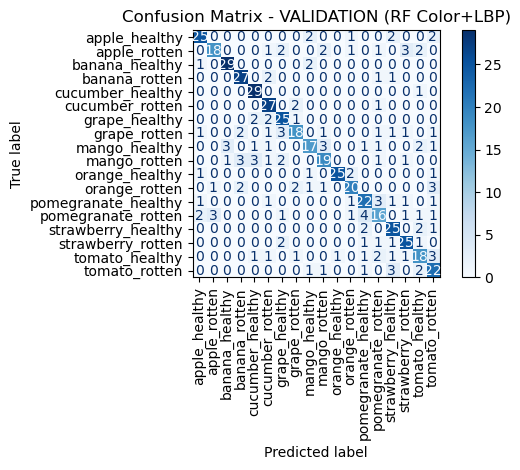


Accuracy TEST: 73.64%

Classification report TEST:

                     precision    recall  f1-score   support

      apple_healthy      0.889     0.750     0.814        32
       apple_rotten      0.684     0.433     0.531        30
     banana_healthy      0.903     0.875     0.889        32
      banana_rotten      0.784     0.935     0.853        31
   cucumber_healthy      0.806     0.935     0.866        31
    cucumber_rotten      0.737     0.933     0.824        30
      grape_healthy      0.656     0.677     0.667        31
       grape_rotten      0.581     0.600     0.590        30
      mango_healthy      0.700     0.467     0.560        30
       mango_rotten      0.600     0.774     0.676        31
     orange_healthy      0.885     0.767     0.821        30
      orange_rotten      0.750     0.600     0.667        30
pomegranate_healthy      0.852     0.742     0.793        31
 pomegranate_rotten      0.633     0.633     0.633        30
 strawberry_healthy      0.667 

<Figure size 1000x800 with 0 Axes>

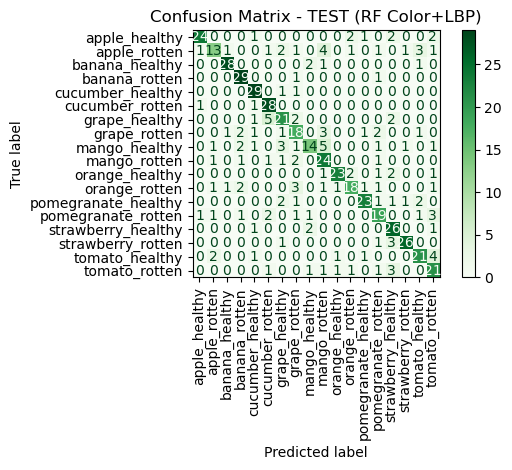

RIASSUNTO FINALE
Validation accuracy (RF Color+LBP, 8x aug): 74.27%
Test accuracy (RF Color+LBP, 8x aug):       73.64%


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

print("="*80)
print("MODELLO FINALE: RF su Color+LBP+Morphology (68 feat) con augmentation 8x")
print("="*80)

# 1) Allena RF finale su TRAIN
rf_final = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    max_features="sqrt",
    random_state=random_state,
    n_jobs=-1
)
rf_final.fit(X_train_full_std, y_train_np)

classes = rf_final.classes_

# 2) VALIDATION
y_val_pred = rf_final.predict(X_val_full_std)
acc_val = accuracy_score(y_val_np, y_val_pred)
print(f"\nAccuracy VALIDATION: {acc_val*100:.2f}%\n")

print("Classification report VALIDATION:\n")
print(classification_report(y_val_np, y_val_pred, digits=3))

cm_val = confusion_matrix(y_val_np, y_val_pred, labels=classes)

plt.figure(figsize=(10, 8))
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=classes)
disp_val.plot(include_values=True, cmap="Blues", xticks_rotation=90, colorbar=True)
plt.title("Confusion Matrix - VALIDATION (RF Color+LBP)")
plt.tight_layout()
plt.show()

# 3) TEST (una sola volta)
y_test_pred = rf_final.predict(X_test_full_std)
acc_test = accuracy_score(y_test_np, y_test_pred)
print(f"\nAccuracy TEST: {acc_test*100:.2f}%\n")

print("Classification report TEST:\n")
print(classification_report(y_test_np, y_test_pred, digits=3))

cm_test = confusion_matrix(y_test_np, y_test_pred, labels=classes)

plt.figure(figsize=(10, 8))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classes)
disp_test.plot(include_values=True, cmap="Greens", xticks_rotation=90, colorbar=True)
plt.title("Confusion Matrix - TEST (RF Color+LBP)")
plt.tight_layout()
plt.show()

print("="*80)
print("RIASSUNTO FINALE")
print("="*80)
print(f"Validation accuracy (RF Color+LBP, 8x aug): {acc_val*100:.2f}%")
print(f"Test accuracy (RF Color+LBP, 8x aug):       {acc_test*100:.2f}%")


Errori totali: 145 / 550


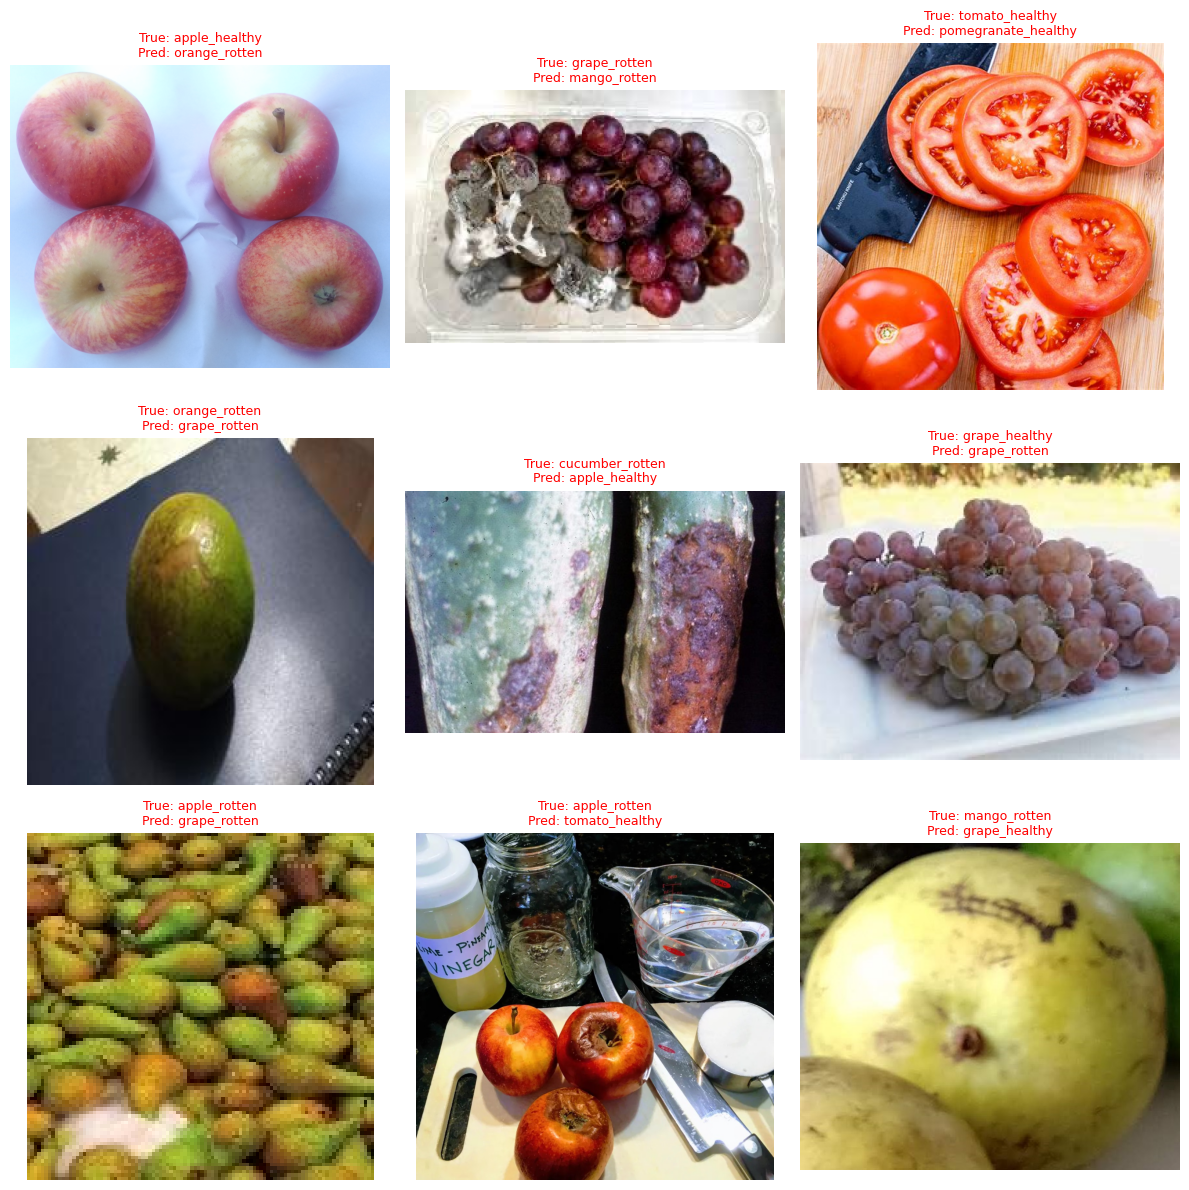

In [22]:
# Identifica gli errori
errors_idx = np.where(y_test_pred != y_test_np)[0]
print(f"Errori totali: {len(errors_idx)} / {len(y_test_np)}")

# Visualizza i primi 9 errori
import matplotlib.pyplot as plt
from PIL import Image
import os

root_dir = "dataset"

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, idx in enumerate(errors_idx[:9]):
    img_name = X_test.iloc[idx]["name"]
    img_path = os.path.join(root_dir, img_name)
    img = Image.open(img_path)
    
    true_label = y_test_np[idx]
    pred_label = y_test_pred[idx]
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=9, color='red')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Color + LBP + K-means + RF

## TTA (aug of val/test and mean of the classifications)

## ENSEMBLE VOTING 

## SFS (RF) on Color + LBP

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

sfs_rf = SequentialFeatureSelector(
    rf_base,
    n_features_to_select=20,
    direction="forward",
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

sfs_rf.fit(X_train_cl_std, y_train_np)
mask_rf = sfs_rf.get_support()
idx_rf = np.where(mask_rf)[0]
print("RF-SFS, num feature selezionate:", len(idx_rf))
print("Indici RF-SFS:", idx_rf)


X_train_rf_sfs = X_train_cl_std[:, mask_rf]
X_val_rf_sfs = X_val_cl_std[:, mask_rf]
X_test_rf_sfs = X_test_cl_std[:, mask_rf]

print(X_train_rf_sfs.shape, X_val_rf_sfs.shape, X_test_rf_sfs.shape)


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

rf_strong = RandomForestClassifier(
    n_estimators=400, max_depth=30, max_features="sqrt", random_state=42, n_jobs=-1
)
rf_strong.fit(X_train_rf_sfs, y_train_np)
y_val_pred_rf = rf_strong.predict(X_val_rf_sfs)
print("Val acc RF forte su RF-SFS:", accuracy_score(y_val_np, y_val_pred_rf) * 100, "%")

svm_rbf = SVC(kernel="rbf", C=20)
svm_rbf.fit(X_train_rf_sfs, y_train_np)
y_val_pred_svm = svm_rbf.predict(X_val_rf_sfs)
print("Val acc SVM RBF su RF-SFS:", accuracy_score(y_val_np, y_val_pred_svm) * 100, "%")

## SFS (SVC) on Color + LBP

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SequentialFeatureSelector


svm_base = LinearSVC(C=1.0, random_state=42)

sfs_svm = SequentialFeatureSelector(
    svm_base,
    n_features_to_select=30,
    direction="backward",
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

sfs_svm.fit(X_train_cl_std, y_train_np)
mask_svm = sfs_svm.get_support()
idx_svm = np.where(mask_svm)[0]
print("SVM-SFS, num feature selezionate:", len(idx_svm))
print("Indici SVM-SFS:", idx_svm)


X_train_svm_sfs = X_train_cl_std[:, mask_svm]
X_val_svm_sfs = X_val_cl_std[:, mask_svm]
X_test_svm_sfs = X_test_cl_std[:, mask_svm]

print(X_train_svm_sfs.shape, X_val_svm_sfs.shape, X_test_svm_sfs.shape)


rf_strong_svm = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    random_state=42,
    n_jobs=-1
)
rf_strong_svm.fit(X_train_svm_sfs, y_train_np)
y_val_pred_rf2 = rf_strong_svm.predict(X_val_svm_sfs)
print("Val acc RF forte su SVM-SFS:", accuracy_score(y_val_np, y_val_pred_rf2)*100, "%")

svm_rbf2 = SVC(kernel="rbf", C=20, gamma="scale")
svm_rbf2.fit(X_train_svm_sfs, y_train_np)
y_val_pred_svm2 = svm_rbf2.predict(X_val_svm_sfs)
print("Val acc SVM RBF su SVM-SFS:", accuracy_score(y_val_np, y_val_pred_svm2)*100, "%")
